The goal of this notebook is to **use Google's GTFS data to find out how many trains are operating in the NYC Subway at any given time**. Along the way, we will also how frequency changes throughout the train schedule and examine how frequency interacts with ridership numbers.

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

[time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# getting functions from the parent directory
library_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if library_path not in sys.path:
    sys.path.append(library_path)
from functions import *

# Schedule Data

In [3]:
routes_df = pd.read_csv("../data/google_transit/routes.txt")
stop_times_df = pd.read_csv("../data/google_transit/stop_times.txt")
stops_df = pd.read_csv("../data/google_transit/stops.txt")

## Frequency Data 
(that I made)

In [4]:
average_trip_time_per_service = pd.read_csv("../saved_data/average_trip_time_per_service.csv", index_col=0)
hourly_route_trip_freq = pd.read_csv("../saved_data/hourly_route_trip_freq.csv", index_col=0)
trip_interval_route_freq = pd.read_csv("../saved_data/trip_interval_route_freq.csv", index_col=0)
route_frequency_by_day = pd.read_csv("../saved_data/route_frequency_by_day.csv", index_col=0)

In [5]:
# sorting the trip interval data by service
# sorting train_time_interval by time of day
time_of_day_sorting = {'Late Night': 0, 'Rush Hour AM': 1, 'Midday': 2
                                     , 'Rush Hour PM': 3, 'Evening': 4, 'Weekend': 5}
trip_interval_route_freq = trip_interval_route_freq.sort_values(by= ['route_id', 'train_time_interval']
                                    , key=lambda x: x.map(time_of_day_sorting)).reset_index(drop=True)

## Removing SIR 

In [6]:
hourly_route_trip_freq = hourly_route_trip_freq[hourly_route_trip_freq['route_id']!='SI']
trip_interval_route_freq = trip_interval_route_freq[trip_interval_route_freq['route_id']!='SI']
route_frequency_by_day = route_frequency_by_day[route_frequency_by_day['route_id']!='SI']

## Adjustments to Data

In [7]:
daily_route_trip_freq = hourly_route_trip_freq.groupby(['route_id', 'day_of_week']).sum() / 24
daily_route_trip_freq = daily_route_trip_freq.drop(columns=['departure_hour']).reset_index()
daily_route_trip_freq = daily_route_trip_freq.round(1)

In [8]:
route_frequency_weekday = route_frequency_by_day[route_frequency_by_day.day_of_week=='Weekday']
route_frequency_weekday['trains_per_hour'] = route_frequency_weekday['trains_per_hour'] * 5
route_frequency_weekend = route_frequency_by_day[route_frequency_by_day.day_of_week!='Weekday']
# creating overall trains per hour 
route_frequency_overall = pd.concat([route_frequency_weekend, route_frequency_weekday])
daily_route_frequency = pd.DataFrame(round(route_frequency_overall.groupby('route_id')['trains_per_hour'].sum() / 7, 1))
daily_route_frequency = daily_route_frequency.merge(average_trip_time_per_service[['route_id', 'route_time_minutes']], on='route_id')
daily_route_frequency['avg_num_of_trains_running'] =  round((daily_route_frequency['route_time_minutes'] / 60) * \
                                                        daily_route_frequency['trains_per_hour'] * 2, 1)

# Number of Train (sets) Running 

## Daily

In [9]:
# services with the most trains running overall
daily_route_trip_freq[['route_id', 'day_of_week', "Avg_num_trains_running"]].sort_values(by='Avg_num_trains_running'
                                                                          , ascending=False)[0:5]

,route_id,day_of_week,Avg_num_trains_running
36,F,Weekday,27
60,N,Weekday,23
17,6,Weekday,22
5,2,Weekday,22
23,A,Weekday,21


In [10]:
# 290 trains running on average!
# this is trains moving at any one moment (Grand Central Shuttle counts as 1/4 of a train)
round(daily_route_frequency['avg_num_of_trains_running'].sum(), 1)

np.float64(290.2)

## Train Time Interval

In [11]:
trip_interval_route_freq[['route_id', 'train_time_interval', 'Avg_num_trains_running']].sort_values(
                                                    by='Avg_num_trains_running', ascending=False)[0:5]

,route_id,train_time_interval,Avg_num_trains_running
36,F,Rush Hour AM,42
68,N,Midday,37
53,6,Midday,34
60,F,Midday,34
25,2,Rush Hour AM,34


In [12]:
# looking at train time interval overall
interval_number_of_trains_dict = {}
for value in trip_interval_route_freq['train_time_interval'].unique():
    interval_avg_num_trains = trip_interval_route_freq[trip_interval_route_freq['train_time_interval']==value
                                                                                ]['Avg_num_trains_running'].sum()
    interval_number_of_trains_dict[value] = round(interval_avg_num_trains, 1)
train_time_interval_df = pd.DataFrame.from_dict(interval_number_of_trains_dict, orient='index'
                                                , columns=['Avg_number_of_trains_in_interval'])

In [13]:
train_time_interval_df.sort_values(by='Avg_number_of_trains_in_interval').round()

,Avg_number_of_trains_in_interval
Late Night,124
Weekend,250
Rush Hour PM,301
Evening,351
Midday,450
Rush Hour AM,456


In [14]:
# which routes has the most service per train time interval
# are there ties for the frequency??
trip_interval_route_freq[trip_interval_route_freq['headway_minutes'] < 1000].sort_values(
        by='Avg_num_trains_running').drop_duplicates(subset='train_time_interval', keep='last')

,route_id,train_time_interval,trains_per_hour,headway_seconds,headway_minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
7,A,Late Night,5,688,12,4900,82,14
121,2,Weekend,6,562,9,5751,96,20
84,F,Rush Hour PM,8,450,8,5859,98,26
108,F,Evening,9,389,6,5859,98,30
68,N,Midday,16,230,4,4217,70,37
36,F,Rush Hour AM,13,277,5,5859,98,42


### Plotting the Change in Frequency by Train Time Interval

In [39]:
mean_interval_headway_dict = dict(trip_interval_route_freq.groupby(['train_time_interval'])['headway_minutes'].mean())
trip_interval_route_freq.columns = ['route_id', 'Train Time Interval', 'trains_per_hour'
                                   , 'headway_seconds', 'Headway Minutes', 'route_time_seconds'
                                   , 'route_time_minutes', 'Avg_num_trains_running']

In [41]:
# removing edge cases 
# essentially the late night B, C, and GS have trains which have services barely crossing into this interval
trip_interval_route_freq_trimmed = trip_interval_route_freq[trip_interval_route_freq['Headway Minutes']<31]

In [42]:
trip_interval_route_freq_trimmed

,route_id,Train Time Interval,trains_per_hour,headway_seconds,Headway Minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
0,1,Late Night,3,"1,132",19,3409,57,6
1,2,Late Night,3,"1,190",20,5751,96,10
2,3,Late Night,3,"1,151",19,3476,58,6
3,4,Late Night,3,"1,097",18,4168,70,8
4,5,Late Night,3,"1,170",20,3292,55,6
...,...,...,...,...,...,...,...,...
137,L,Weekend,12,294,5,2239,37,15
138,M,Weekend,6,583,10,2238,37,8
139,N,Weekend,5,708,12,4217,70,12
140,Q,Weekend,7,534,9,3850,64,14


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Late Night'),
  Text(1, 0, 'Rush Hour AM'),
  Text(2, 0, 'Midday'),
  Text(3, 0, 'Rush Hour PM'),
  Text(4, 0, 'Evening'),
  Text(5, 0, 'Weekend')])

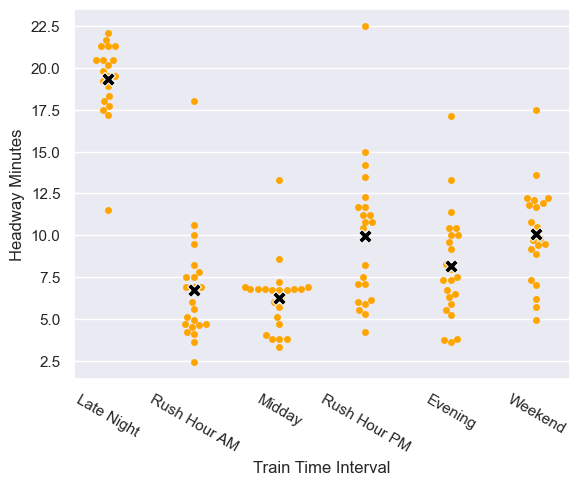

In [43]:
ax = sns.swarmplot(x='Train Time Interval', y='Headway Minutes', data=trip_interval_route_freq_trimmed, color='orange')
df_means = trip_interval_route_freq_trimmed.groupby(['Train Time Interval'])['Headway Minutes'].agg("mean").reset_index()
sns.scatterplot(x='Train Time Interval', y='Headway Minutes', marker='X', color='black', s=100, zorder=3, ax=ax, legend=False, data=df_means)
plt.xticks(rotation=330)
# plt.savefig("../saved_data/interval_headways.png") 

## Hourly

In [44]:
hourly_route_trip_freq['day_hour'] = [hourly_route_trip_freq['day_of_week'][idx] + "_" \
                                        + str(hourly_route_trip_freq['departure_hour'][idx])
                                            for idx in range(hourly_route_trip_freq.shape[0])]
hourly_route_trip_freq[['route_id', 'day_hour', 'Avg_num_trains_running']].sort_values(
                                                    by='Avg_num_trains_running', ascending=False)[0:5]

,route_id,day_hour,Avg_num_trains_running
845,F,Weekday_7,49
846,F,Weekday_8,42
854,F,Weekday_16,39
855,F,Weekday_17,39
856,F,Weekday_18,39


In [45]:
hourly_number_of_trains_dict = {}
for value in hourly_route_trip_freq['day_hour'].unique():
    hourly_avg_num_trains = hourly_route_trip_freq[hourly_route_trip_freq['day_hour']==value
                                                                                ]['Avg_num_trains_running'].sum()
    hourly_number_of_trains_dict[value] = round(hourly_avg_num_trains, 1)
train_time_hourly_df = pd.DataFrame.from_dict(hourly_number_of_trains_dict, orient='index'
                                                , columns=['Avg_number_of_trains_in_hour'])

### Most frequent number of trains running

In [46]:
# most frequent hours to use the subway
train_time_hourly_df.sort_values(by='Avg_number_of_trains_in_hour', ascending=False)[0:10]

,Avg_number_of_trains_in_hour
Weekday_16,499
Weekday_7,489
Weekday_8,478
Weekday_17,438
Weekday_15,417
Weekday_18,416
Weekday_9,413
Weekday_6,402
Weekday_19,395
Weekday_13,389


### Least frequent number of trains running

In [47]:
# least frequent hours to use the subway
train_time_hourly_df.sort_values(by='Avg_number_of_trains_in_hour')[0:10]

,Avg_number_of_trains_in_hour
Saturday_3,122
Saturday_2,122
Sunday_4,122
Sunday_2,122
Sunday_3,122
Weekday_2,122
Weekday_3,122
Weekday_0,123
Weekday_1,123
Saturday_1,123


### Plotting number of trains runnings by Hour 

In [48]:
train_time_hourly_df_day = [x.split("_")[0] for x in train_time_hourly_df.index.values]
train_time_hourly_df_hour = [x.split("_")[1] for x in train_time_hourly_df.index.values]
train_time_hourly_df.columns = ['Avg Number of Trains in an Hour']
train_time_hourly_df['Day'] = train_time_hourly_df_day
train_time_hourly_df['Hour'] = train_time_hourly_df_hour

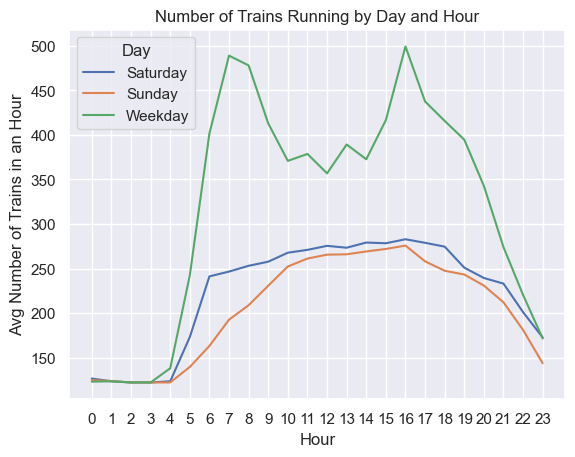

In [49]:
hourly_number_of_trains_by_day = sns.lineplot(data=train_time_hourly_df, x='Hour'
                                       , y='Avg Number of Trains in an Hour', hue='Day')
hourly_number_of_trains_by_day.set_title('Number of Trains Running by Day and Hour')
fig = hourly_number_of_trains_by_day.get_figure()
# fig.savefig("../saved_data/hourly_number_of_trains_by_day.png") 

# Data Visualizations

In [50]:
# the route length shifts variabley so the frequency calculations are incorrect
sorted_routes = route_frequency_by_day[route_frequency_by_day
                                 ['day_of_week']=='Weekday'].sort_values(by='trains_per_hour')['route_id'].values


## Daily Average Frequency

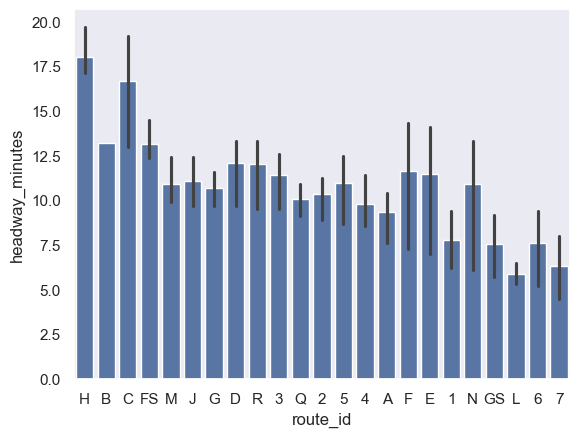

In [51]:
# with error bar 
ax = sns.barplot(data = route_frequency_by_day, x = 'route_id', y='headway_minutes'
                 , order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

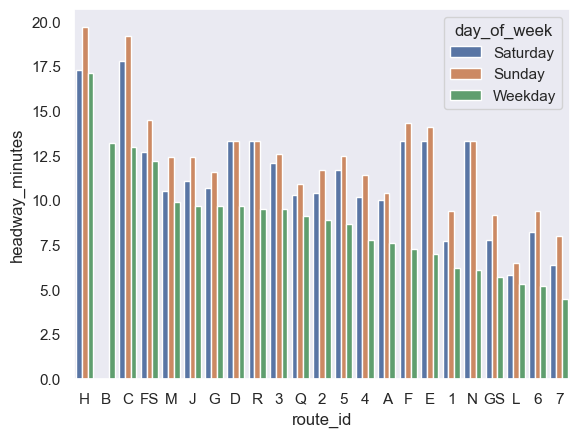

In [52]:
# separated by day 
ax = sns.barplot(data = route_frequency_by_day, x = 'route_id', y='headway_minutes'
                 , hue='day_of_week', order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

## Frequency by Interval

Late Night


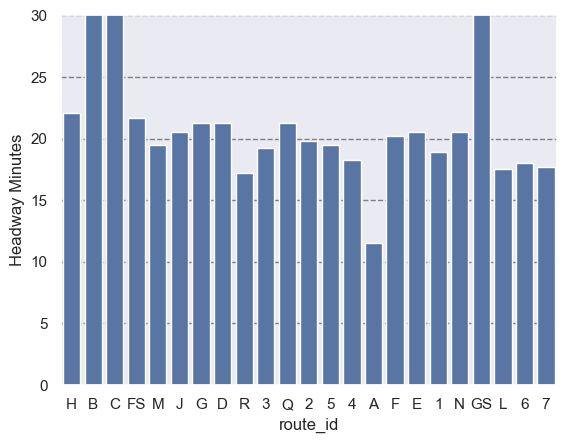

Rush Hour AM


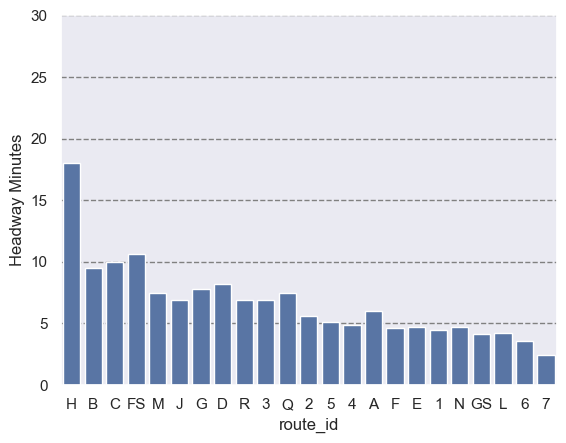

Midday


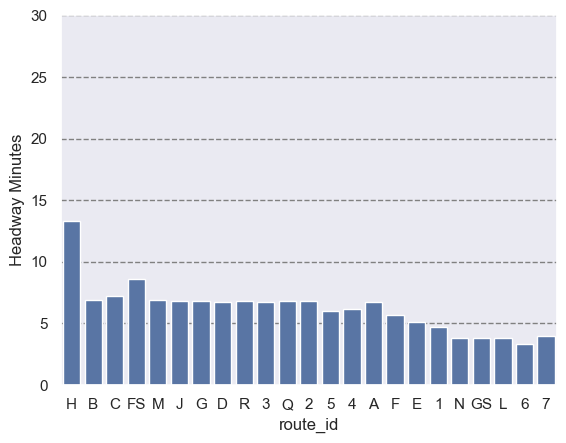

Rush Hour PM


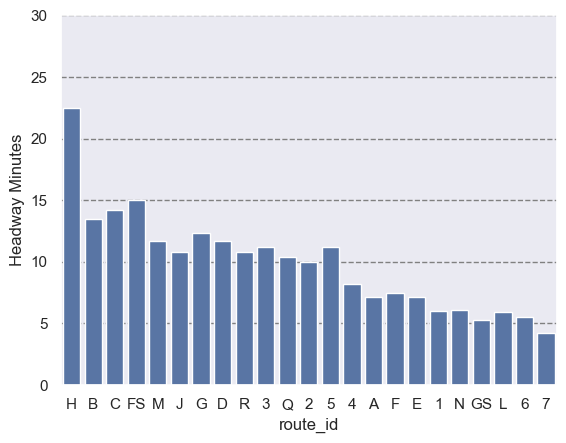

Evening


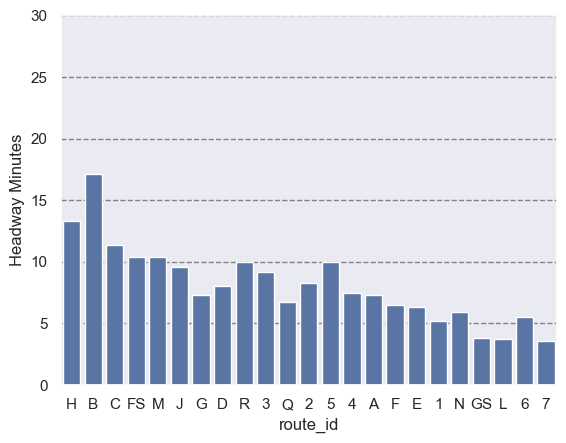

Weekend


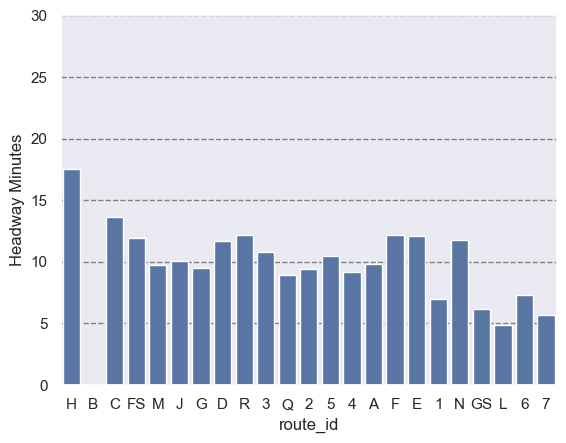

In [53]:
for interval in time_of_day_sorting.keys():
    print(interval)
    ax = sns.barplot(data=trip_interval_route_freq[trip_interval_route_freq
                                    ['Train Time Interval']==interval]
                                 , x = 'route_id', y='Headway Minutes', order=sorted_routes)
#     ax.title(interval)
    ax.grid(color='gray', linestyle='dashed')
    ax.grid(axis='x')
    ax.set_ylim(ymin=0, ymax=30)
    plt.show()

### Best and Worst Performers by Time of Day

In [54]:
# lowest  -- removing inf values first
# it's a tie for worst so let's just make it SIR lol 
trip_interval_route_freq[trip_interval_route_freq['Headway Minutes'] < 1000].sort_values(
    by='Headway Minutes').drop_duplicates(subset='Train Time Interval', keep='last')

,route_id,Train Time Interval,trains_per_hour,headway_seconds,Headway Minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
64,H,Midday,4,800,13,602,10,2
104,B,Evening,4,"1,029",17,4826,80,9
135,H,Weekend,3,"1,050",18,602,10,1
40,H,Rush Hour AM,3,"1,080",18,602,10,1
88,H,Rush Hour PM,3,"1,350",22,602,10,1
8,B,Late Night,0,"17,550",292,4826,80,0


In [55]:
trip_interval_route_freq[trip_interval_route_freq['Headway Minutes'] < 1000].sort_values(
    by='Headway Minutes', ascending=False).drop_duplicates(subset='Train Time Interval', keep='last')

,route_id,Train Time Interval,trains_per_hour,headway_seconds,Headway Minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
7,A,Late Night,5,688,12,4900,82,14
137,L,Weekend,12,294,5,2239,37,15
78,7,Rush Hour PM,14,249,4,2244,37,18
102,7,Evening,16,218,4,2244,37,21
53,6,Midday,18,200,3,3447,58,34
30,7,Rush Hour AM,25,146,2,2244,37,31


## Visualizing Hourly Frequency within a Service

In [56]:
# plot the headway minutes for a single line
l_train_hourly_df = hourly_route_trip_freq[hourly_route_trip_freq['route_id']=='L']
l_train_hourly_df_trimmed = l_train_hourly_df[['day_of_week', 'departure_hour', 'headway_seconds'
                                               , 'headway_minutes', 'Avg_num_trains_running', 'day_hour']]

<Axes: xlabel='departure_hour', ylabel='headway_minutes'>

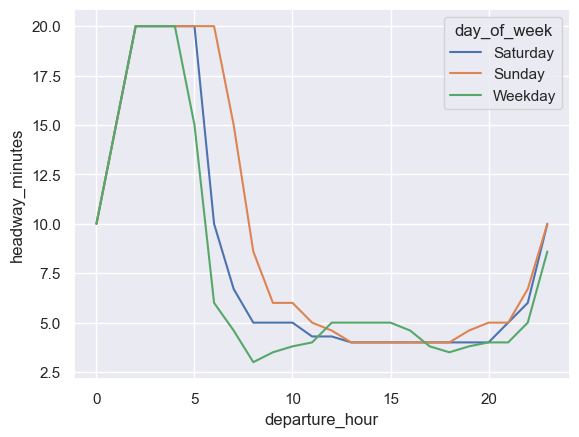

In [57]:
sns.lineplot(data=l_train_hourly_df_trimmed, x='departure_hour', y='headway_minutes', hue='day_of_week')

## Comparing All Services
at rush hour

In [58]:
all_rush_hour_trains = trip_interval_route_freq[
                            trip_interval_route_freq['Train Time Interval'].str.contains("Rush")]

In [59]:
all_rush_hour_trains.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 24 to 94
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                46 non-null     object 
 1   Train Time Interval     46 non-null     object 
 2   trains_per_hour         46 non-null     float64
 3   headway_seconds         46 non-null     float64
 4   Headway Minutes         46 non-null     float64
 5   route_time_seconds      46 non-null     int64  
 6   route_time_minutes      46 non-null     float64
 7   Avg_num_trains_running  46 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.2+ KB


In [60]:
all_rush_hour_trains = trip_interval_route_freq[
                            trip_interval_route_freq['Train Time Interval'].str.contains("Rush")]
rush_hour_trains_avg = all_rush_hour_trains.groupby('route_id')['Headway Minutes'].sum() / 2

In [61]:
rush_hour_trains_avg = rush_hour_trains_avg.sort_values(ascending=False).reset_index()

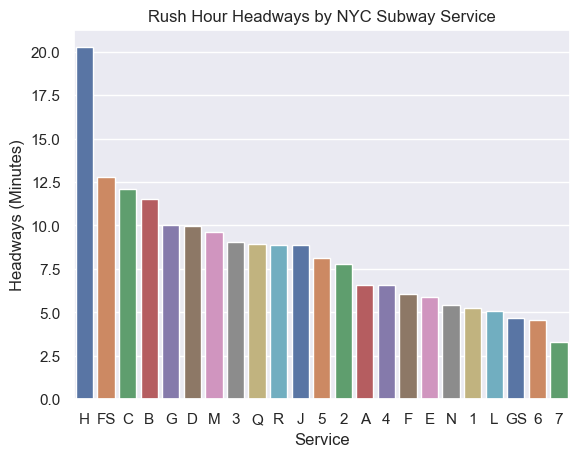

In [62]:
# sns.set(style="line")
ax = sns.barplot(data=rush_hour_trains_avg, x='route_id', y='Headway Minutes', palette='deep')
ax.set_title('Rush Hour Headways by NYC Subway Service')
ax.set_ylabel('Headways (Minutes)')
ax.set_xlabel('Service')
# ax.grid(b=True, axis='y')
fig = ax.get_figure()
# fig.savefig("../saved_data/service_comparison_rush_hour.png") 

# TPH and Train Time Interval Ratios
Do the services all have the same service ratios between each train time interval?

In [67]:
# Finding the percentage of service for each route_id/service divided by time interval service 
service_ratio_list = [None for x in range(len(trip_interval_route_freq))]
for service in trip_interval_route_freq.route_id.unique():
    # get the number of trains running for each service - train time interval
    # divide by total and insert these new numbers at the specified index for service_ratio_list
    filtered_df_to_service = trip_interval_route_freq[trip_interval_route_freq['route_id']==service]['Avg_num_trains_running'] 
    single_service_ratio_df = pd.DataFrame(round(filtered_df_to_service/filtered_df_to_service.sum(), 2)*100)
    for idx in single_service_ratio_df.index:
        service_ratio_list[idx] = single_service_ratio_df.loc[idx].values[0]
# alt. names: train_time_interval_ratio, percentage 
trip_interval_route_freq['single_service_ratio'] = service_ratio_list

IndexError: list assignment index out of range

In [68]:
# compare each route_id + train time interval to average train time interval ratio
all_routes_service_ratio = round(trip_interval_route_freq.groupby('Train Time Interval')
            ['Avg_num_trains_running'].sum()/ trip_interval_route_freq['Avg_num_trains_running'].sum(), 2)*100

trip_interval_route_freq['mean_service_ratio'] = trip_interval_route_freq['Train Time Interval'].copy().replace(
                                                    all_routes_service_ratio)

trip_interval_route_freq['single_service_ratio_diff'] = trip_interval_route_freq['single_service_ratio'] - \
                                                        trip_interval_route_freq['mean_service_ratio']

KeyError: 'single_service_ratio'

In [69]:
# all services
trip_interval_route_freq[['route_id', 'Train Time Interval','single_service_ratio', 'mean_service_ratio'
                         , 'single_service_ratio_diff']][0:6]

KeyError: "['single_service_ratio', 'single_service_ratio_diff'] not in index"

In [70]:
sns.barplot(data=trip_interval_route_freq, x='route_id', y='single_service_ratio_diff'
            , hue='Train Time Interval')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figure(figsize=(30,12))
plt.show()

ValueError: Could not interpret value `single_service_ratio_diff` for `y`. An entry with this name does not appear in `data`.

In [71]:
# examining one train's service ratio
trip_interval_route_freq[trip_interval_route_freq['route_id']=='1'][['route_id', 'Train Time Interval', 'single_service_ratio']]

KeyError: "['single_service_ratio'] not in index"